#### Lightweight MMM
One of the primary methods Lightweight uses is scaling and normalizing
all of the variables. I previously did the scaling on a Tyson data set
and got most of this to run. I left some of the code in to show
some of the steps necessary to transform a dataset for Lightweight.
Since I made the demo, LightweightMMM has improved some of the issues
with their scaling and model analysis, but even running with dummy data,
some issues are still apparent.

In [19]:
# Import jax.numpy and any other library we might need.
import jax
import tensorflow as tf
import sklearn
import jax.numpy as jnp
import numpyro
import pandas as pd

Jax and Pyro are good, but they are a bit touchy and require their environments
to be very particular. It is easier to run in a Linux environment, but some of the options to speed up jax or numpyro can affect CUDA

In [20]:
numpyro.set_host_device_count(2)

In [21]:
jax.local_device_count()

1

In [22]:
# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

## Organising the data for modelling

In [23]:
SEED = 42

In [24]:
data_size = 104 + 13
n_media_channels = 3
n_extra_features = 1

In [25]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=data_size,
    n_media_channels=n_media_channels,
    n_extra_features=n_extra_features)

This can take a little practice. Deciding how to set the channels and then scaling them before analysis is not as intuitive as other methods.

In [26]:
# Split and scale data.
split_point = data_size - 13
# Media data
media_data_train = jnp.asarray(media_data[:split_point])
media_data_test = jnp.asarray(media_data[split_point:])
# Extra features
extra_features_train = jnp.asarray(extra_features[:split_point])
extra_features_test = jnp.asarray(extra_features[split_point:])
# Target
target_train = jnp.asarray(target[:split_point])
target_test = jnp.asarray(target[split_point:])

Scaling is essential for many modelling problems and this one is no exception.

We provide the class `CustomScaler` which behaves accordingly with `sklearn`
scalers.

In most cases you will need 3 or 4 scalers. One scaler for the media data, one
for the target and one for costs. Optionally if you are adding extra features
those might need an extra scaler. **It is very important that you save and
"carry with you" those scalers throughout your MMM journey as LighweightMMM will
allow you to re-insert these scalers at different points to ensure everything is
always in the correct scale and results. If some results don't make sense, it
might be a scaling problem.**

A few more details on CustomScaler usage:

This scaler can be used in two fashions for both the multiplication and division
operation. 
- By specifying a value to use for the scaling operation. 
- By specifying an operation used at column level to calculate the value for the
actual scaling operation.

Eg. if one wants to scale the dataset by multiply by 100 you can directly pass
multiply_by=100. Value can also be an array of an appropriate shape by which
to divide or multiply the data. But if you want to multiply by the mean value of each
column, then you can pass multiply_operation=jnp.mean (or any other operation
desired).

Operation parameters have the upper hand in the cases where both values and
operations are passed, values will be ignored in this case.

Consult the full class documentation if you still need to know more.

In this demo we divide the data on media, extra features and the target by their mean to ensure that the result has a mean of 1. This allows the model to be agnostic to the scale of the inputs (e.g. a user can use either the number of sales or the value of sales). The costs are not used in the model directly, they are only used to inform the prior distributions on the media variables (see the [model documentation](https://lightweight-mmm.readthedocs.io/en/latest/models.html) here). These costs have been scaled down by multiplying by 0.15 to reflect typical ranges in MMMs. 

This scaling is quite useful, but for some variables it is reversible, and others it is not. It only affects a few graphs, however.

In [27]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

###### Checking data quality
Before putting data into a model, the data should always be examined by hand to make sure everything is correct, and to check for potential issues that might affect the modeling process. We include a data quality check in LMMM which checks for a few common issues. This is not an exhaustive set of checks, however, and most of the exploratory data anlysis will still have do be done manually based on your judgment.

Note: some of Orbit's required packages only run on 3.7, and others only on 3.8+. Therefore some features work depending on which version of Python you use. The data checks here are not working.

In [29]:
# correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
#     media_data=media_scaler.transform(media_data),
#     target_data=target_scaler.transform(target),
#     cost_data=costs,
#     extra_features_data=extra_features_scaler.transform(extra_features))

AttributeError: module 'lightweight_mmm.preprocessing' has no attribute 'check_data_quality'

Step 1: Checking the correlation matrix

The below cell shows the correlation matrix between all the features, and between each feature and the target. Very positive or very negative correlations (with an absolute value above, say, 0.7 or so) should be treated with caution. In this case you might consider dropping or merging highly correlated features.

In [14]:
# correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format(precision = 3)

Step 2: Checking the variances

The below cell shows the variance of each feature over time. Variances which are lower than the specified low_variance_threshold or higher than the specified high_variance_threshold are marked in red. Make sure you are passing the scaled versions of your media_data and extra_features_data to the data quality checker for these variances before running this check!

In [15]:
# def highlight_variances(x: float,
#                         low_variance_threshold: float=1.0e-3,
#                         high_variance_threshold: float=3.0) -> str:
#
#     if x < low_variance_threshold or x > high_variance_threshold:
#       weight = 'bold'
#       color = 'red'
#     else:
#       weight = 'normal'
#       color = 'black'
#     style = f'font-weight: {weight}; color: {color}'
#     return style
#
# variances.style.applymap(highlight_variances).format(precision = 4)

Step 3: Checking the spend fractions

This check is very straightforward. LMMM uses the total spend for each channel to set the prior on the channel's media contribution coefficient, as well as to calculate ROI later in the analysis. Thus the spend for each channel must be positive (not negative or zero), and ideally each channel should not be a negligibly small fraction of the total spend as well.

In [16]:
# def highlight_low_spend_fractions(x: float,
#                                   low_spend_threshold: float=0.01) -> str:
#     if x < low_spend_threshold:
#       weight = 'bold'
#       color = 'red'
#     else:
#       weight = 'normal'
#       color = 'black'
#     style = f'font-weight: {weight}; color: {color}'
#     return style
#
# spend_fractions.style.applymap(highlight_low_spend_fractions).format(precision = 4)


Step 4: Checking the variance inflation factors

While checking the correlation matrix in step 1 is usually sufficient for detetcing obvious multicollinearity in a dataset, the variance inflation factor is technically the best metric for identifying multicollinear features. Here we list the variance inflation factors for all features. If the number is too high (we use a threshold here of 7, but feel free to adjust to your use case) you might consider dropping or merging features with high variance inflation factors.

In [17]:
# def highlight_high_vif_values(x: float,
#                               high_vif_threshold: float=7.0) -> str:
#     if x > high_vif_threshold:
#       weight = 'bold'
#       color = 'red'
#     else:
#       weight = 'normal'
#       color = 'black'
#     style = f'font-weight: {weight}; color: {color}'
#     return style
#
# variance_inflation_factors.style.applymap(highlight_high_vif_values).format(precision = 4)

### Training the model

The currently available models are the following: 
- hill_adstock - the best but most time-consuming
- adstock 
- carryover

In [54]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")

Training the model will require the following mandatory parameters: 
- media
- total_costs (one value per channel) 
- target

We can optionally also pass the following: 
- extra_features: Other variables to add to the model. 
- degrees_seasonality: Number of degrees to use for seasonality. Default is 3. 
- seasonality_frequency: Frequency of the time period used. Default is 52 as in 52 weeks per year. 
- media_names: Names of the media channels passed. 
- number_warmup: Number of warm up samples. Default is 1000. 
- number_samples: Number of samples during sampling. Default is 1000. 
- number_chains: Number of chains to sample. Default is 2.

In [32]:
number_warmup=1000
number_samples=1000

Depending on your setup, the following code block can be fairly quick or very slow. It depends on your GPU or your multi-core setup.

In [33]:
# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    # degrees_seasonality=1,
    # weekday_seasonality=True,
    # seasonality_frequency=365,
    seed=SEED)

/home/matt/anaconda3/envs/lightweight/lib/python3.7/site-packages/lightweight_mmm/lightweight_mmm.py:361: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  num_chains=number_chains)
sample: 100%|██████████| 2000/2000 [24:30<00:00,  1.36it/s, 1023 steps of size 2.34e-03. acc. prob=0.86]


You can check the summary of your trace by printing a summary:

It is important that each r_hat is below 1.1; it is here.

In [34]:
mmm.print_summary()


                                 mean       std    median      5.0%     95.0%     n_eff     r_hat
ad_effect_retention_rate[0]      0.51      0.29      0.51      0.11      1.00   1192.49      1.00
ad_effect_retention_rate[1]      0.31      0.19      0.29      0.01      0.59    690.09      1.00
ad_effect_retention_rate[2]      0.34      0.24      0.30      0.00      0.70    560.30      1.01
     coef_extra_features[0]      0.02      0.01      0.02      0.00      0.04    787.34      1.00
              coef_media[0]      0.01      0.01      0.01      0.00      0.03   1314.44      1.00
              coef_media[1]      0.14      0.05      0.14      0.05      0.22    376.95      1.00
              coef_media[2]      0.08      0.05      0.07      0.00      0.15    430.39      1.01
              coef_trend[0]     -0.00      0.00     -0.00     -0.00      0.00    977.17      1.00
                 expo_trend      0.66      0.16      0.60      0.50      0.87    626.12      1.00
                exp

We can visualise the posterior distributions of the media effects. Though an oversimplification, channel 0 is skewed heavily towards zero, inferring that channel has little effect on revenue.

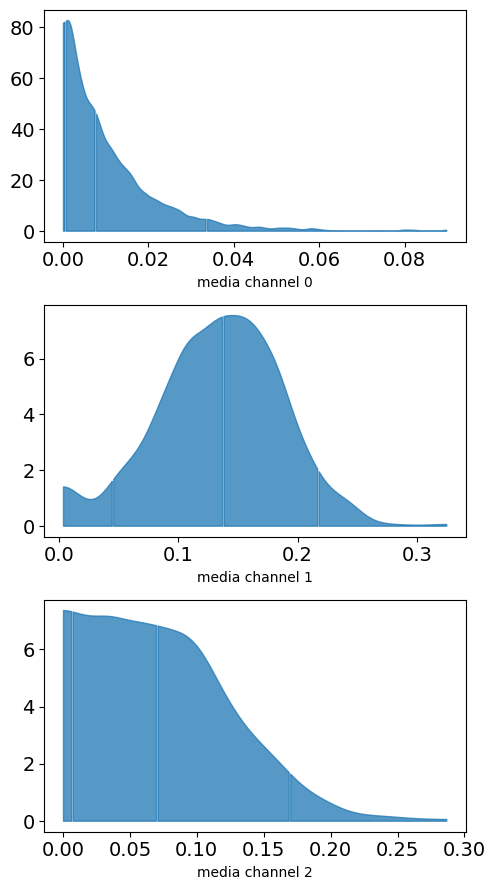

In [35]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)

##### Optional

LightweightMMM also allows you to visualize the prior and posterior distributions for every model parameter at once. Note that we use a kernel density estimator to smooth these distributions for easier interpretability; you may need to adjust the bandwidth of the smoother depending on the shapes of your distributions. Also, this plot can take several minutes to run, especially if using geo-level models. Lowering the number_of_samples_for_prior or restricting to a subset of selected_features can speed up the runtime.
You'll notice that the posterior distributions for the three media channels match up with the above plots, and their means are the estimates of the coefficients for the media channels.

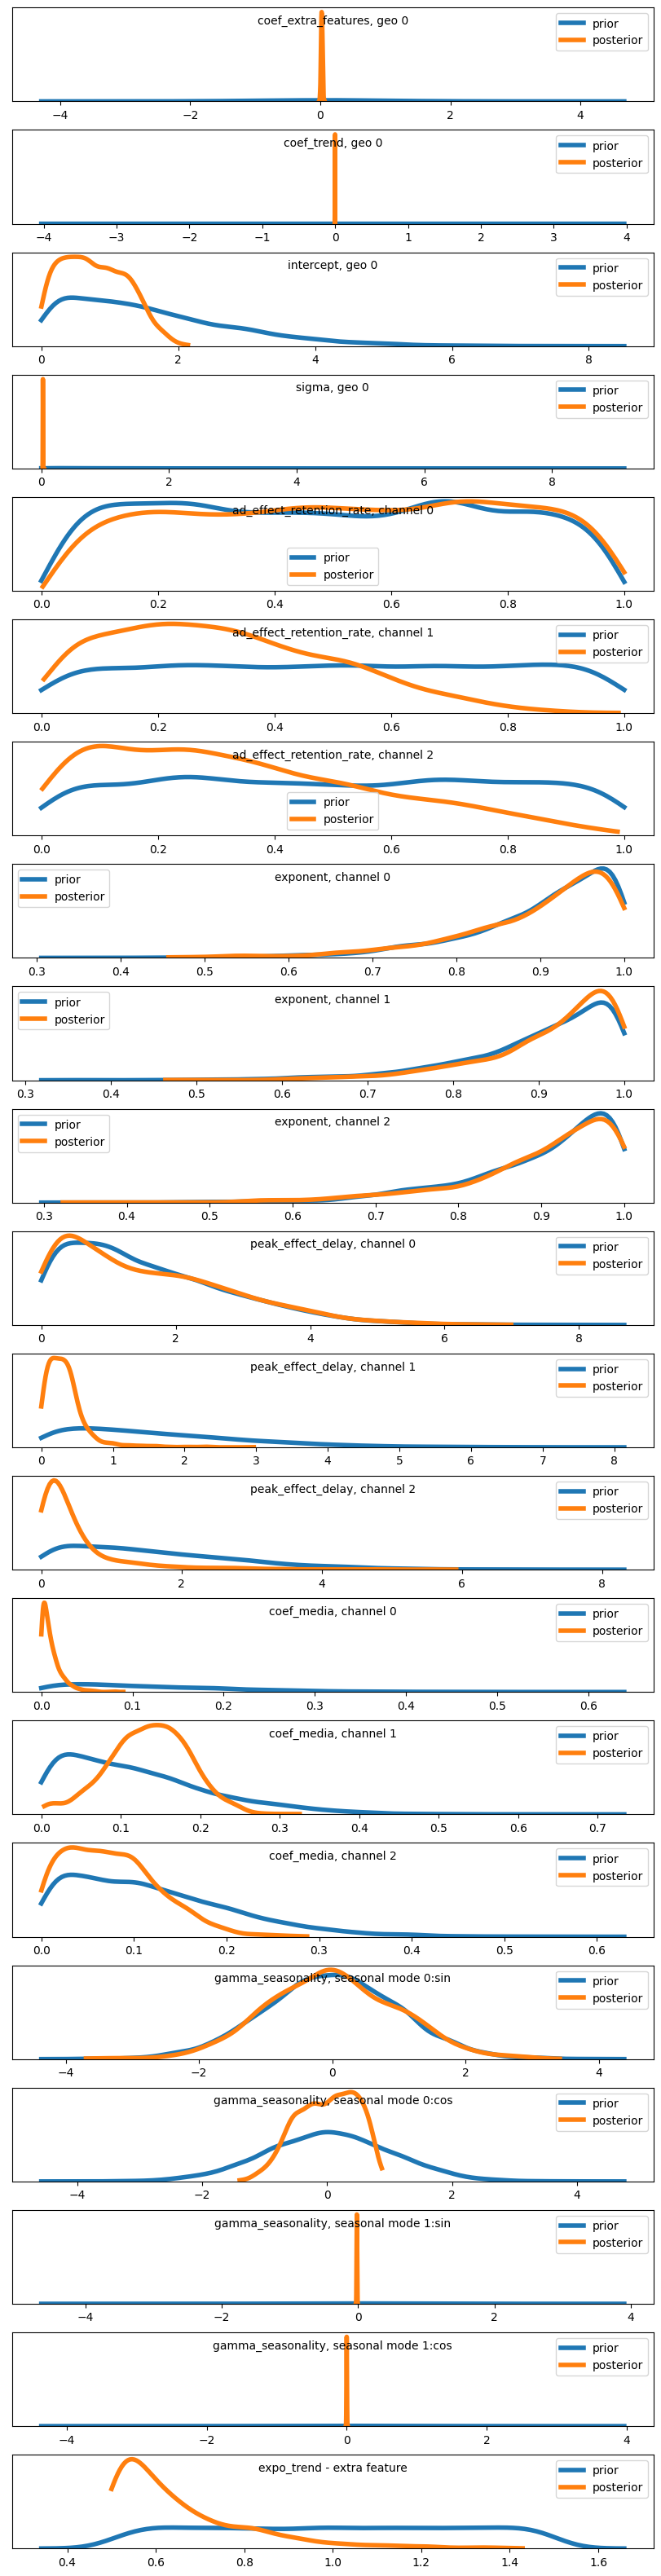

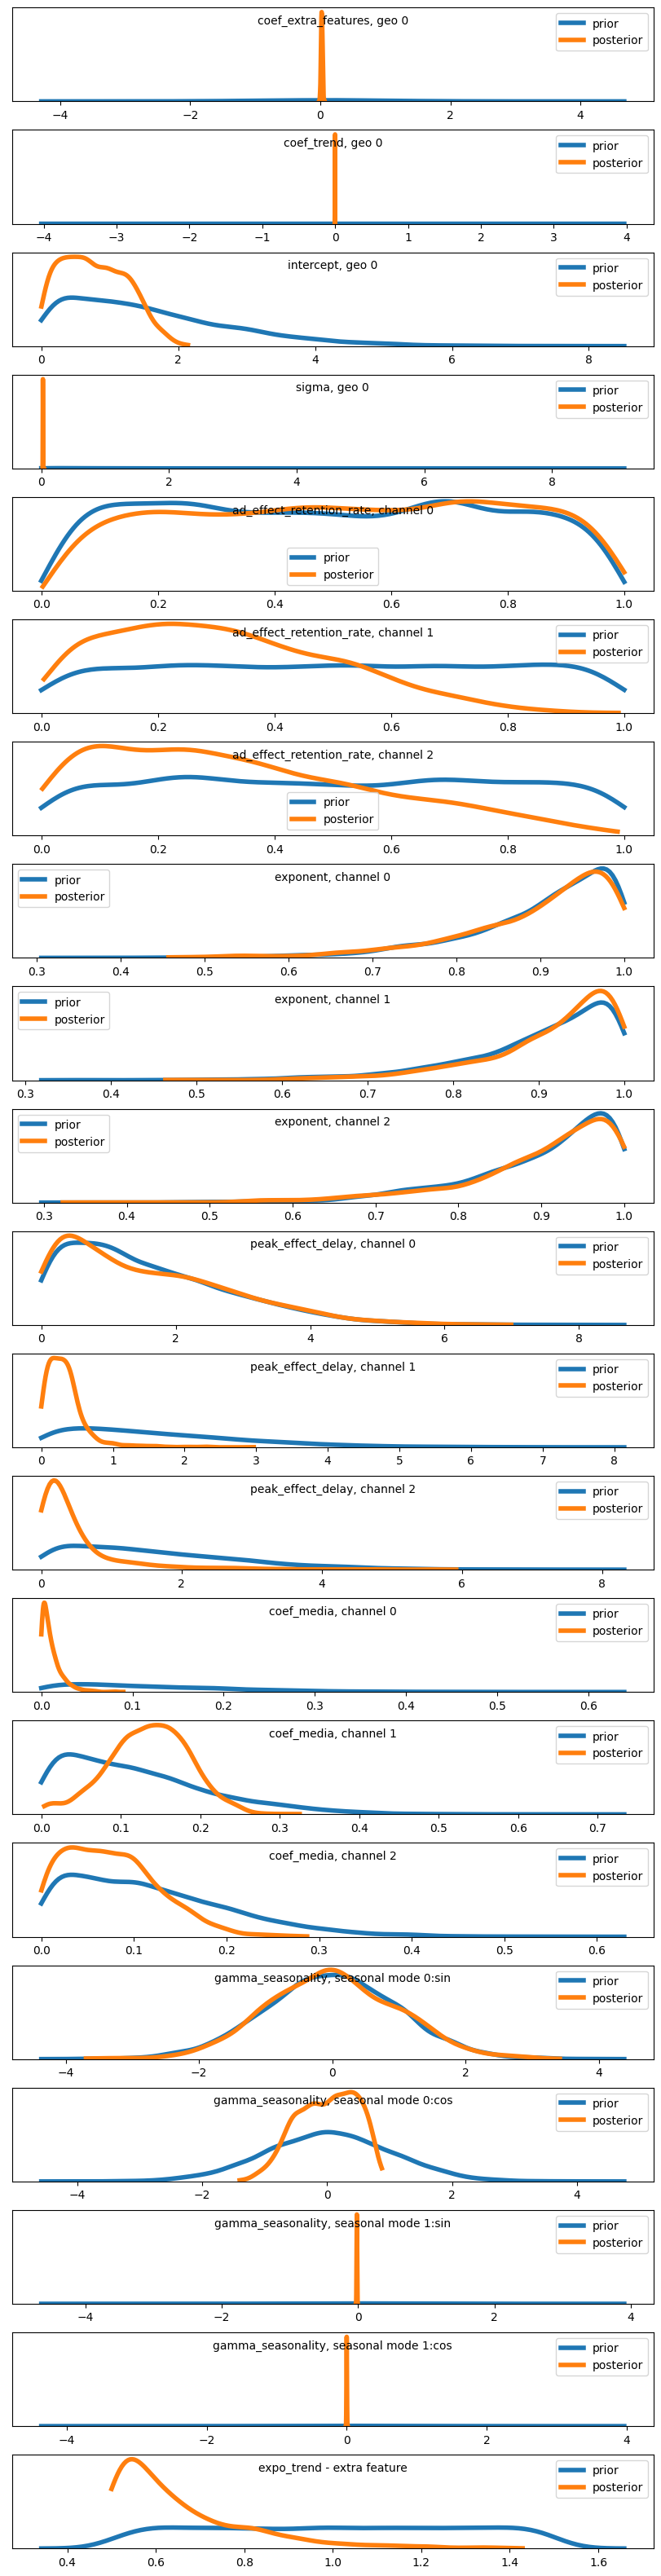

In [36]:
plot.plot_prior_and_posterior(media_mix_model=mmm)

One can also check your model's fit to the training data.

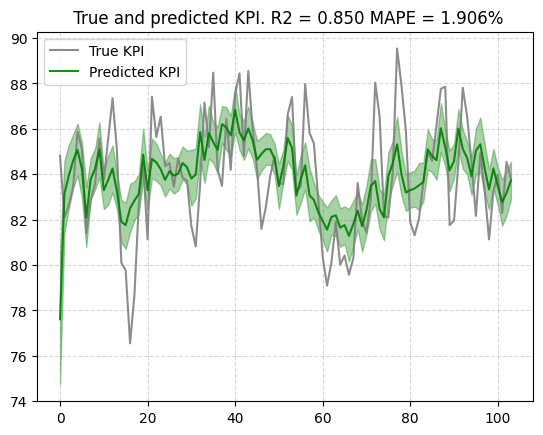

In [37]:
# Here is another example where we can pass the target scaler if you want the plot to be in the "not scaled scale"
plot.plot_model_fit(mmm, target_scaler=target_scaler)

Though r-squared is not quite as trusted in these efforts, with a high r-squared and sufficient MAPE, the predicted KPI is likely not far off.

In [38]:
# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test),
                              extra_features=extra_features_scaler.transform(extra_features_test),
                              seed=SEED)
new_predictions.shape

(2000, 13)

This is the same graph as above, but uses predicted values from the model, and thus has a lower r-squared and MAPE.

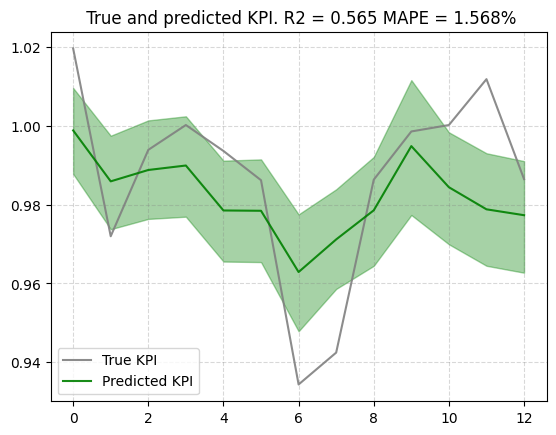

In [39]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target_scaler.transform(target[split_point:]))

### Media insights

In [40]:
prediction = mmm.predict(
    media=media_data_test,
    extra_features=extra_features_test,
    target_scaler=target_scaler
)

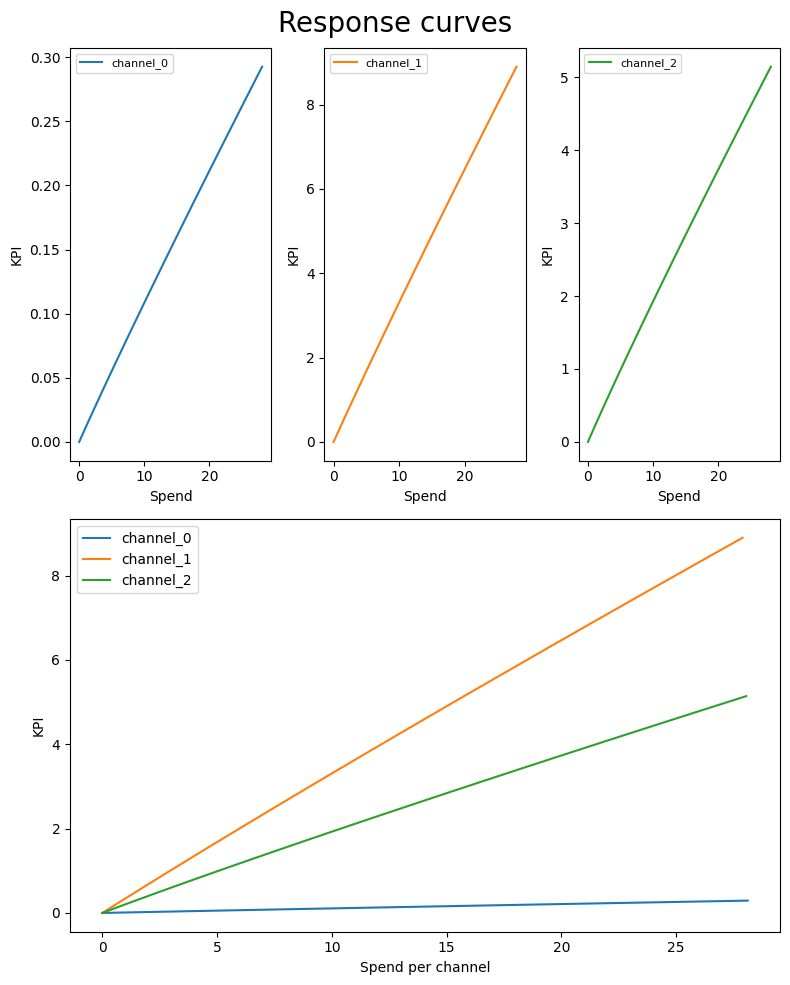

In [41]:
plot.plot_response_curves(media_mix_model=mmm, media_scaler=media_scaler, target_scaler=target_scaler)

In [42]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

We can quickly visualise the estimated media & baseline contribution over time

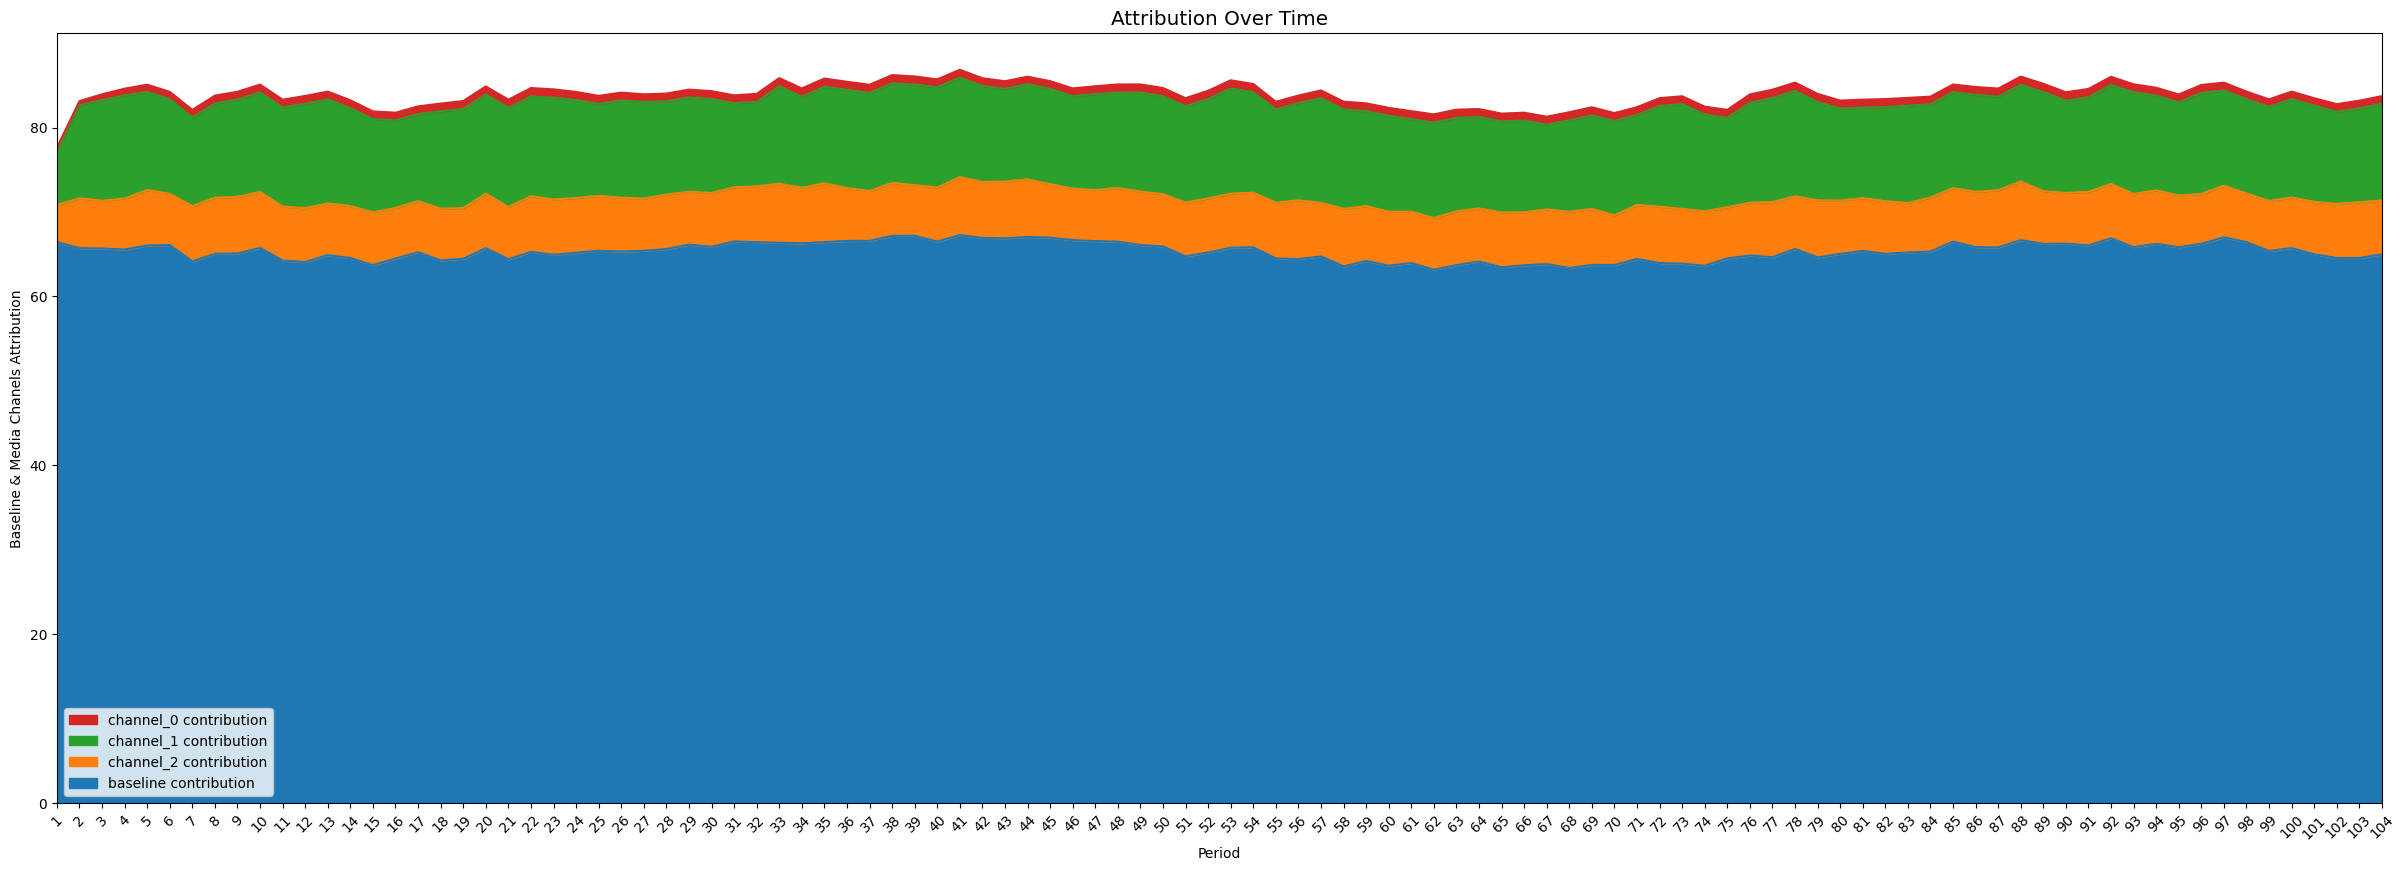

In [43]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

We can quickly visualise the estimated media contributions with their respective
credibility intervals

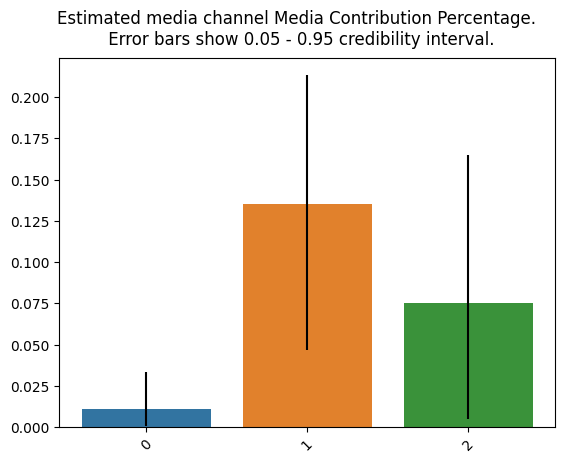

In [44]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage")

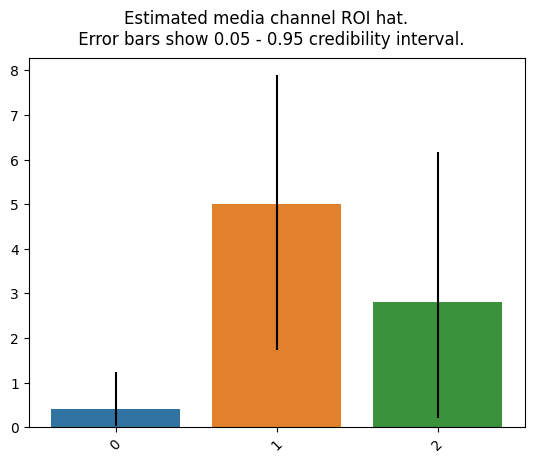

In [45]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat")

Another vital question we can solve with MMMs is how each media channel behaves
individually as we invest more in it.

For that we can plot the curve response of all media channels with the following
function:

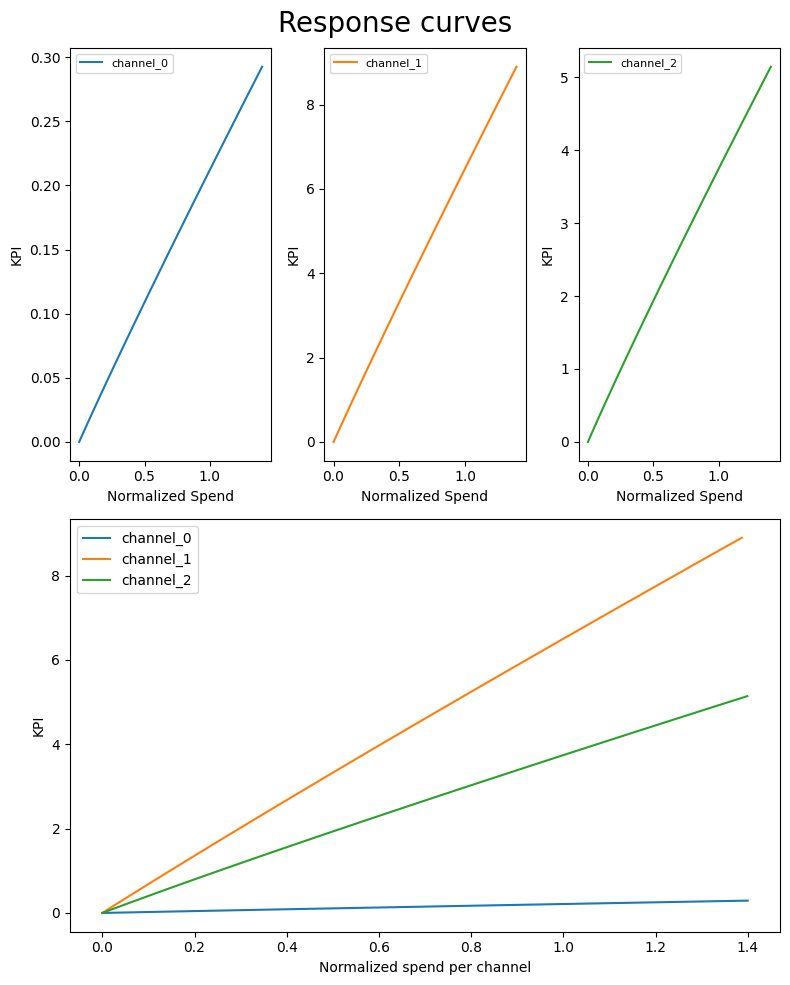

In [46]:
plot.plot_response_curves(
    media_mix_model=mmm, target_scaler=target_scaler, seed=SEED)

### Optimization

This optimization section, while sufficient, is a bit harder to interpret than Robyn's.

The optimization is meant to solve the budget allocation questions for you.
First you need to provide for how long you want to optimize your budget (eg. 15
weeks in this case).

The optimization values will be bounded by +- 20% of the max and min historic
values used for training. Which means the optimization won't recommend to
completely change your strategy but how to make some budget re-allocation.

You can change that percentage with the following parameters: -
bounds_lower_pct - bounds_upper_pct

Which can hold 1 value for all channels or 1 value per channel.

Prices are the average price you would expect for the media units of each
channel. If your data is already a money unit (eg. $) your prices should be an
array of 1s.

In [47]:
prices = jnp.ones(mmm.n_media_channels)

The budget is how much one would like to allocate throughtout the total of
`n_time_periods`. Make sure this amount is inline with the historic spend or
otherwise some conditions/bounds in the optimization might not be met. Testing this with data made from the Utils package, it cannot successfully perform an optimization.

In [48]:
n_time_periods = 12
budget = (jnp.sum(jnp.dot(prices, jnp.asarray(media_data).mean(axis=0)))* n_time_periods) / 100

In [49]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_budget_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_scaler.transform(extra_features_test)[:n_time_periods],
    budget=budget,
    prices=prices,
    media_scaler=media_scaler,
    target_scaler=target_scaler,
    bounds_upper_pct=10,
    max_iterations=200,
    seed=SEED)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -949.3672264957934
            Iterations: 20
            Function evaluations: 162
            Gradient evaluations: 16


If your media data is not in money unit (eg. impressions, clicks, GRPs, etc.), you would need to store the cost per values (eg. CPC) in the prices array and multiply it by solution.x to get the recommended budget allocation.



In [50]:
# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

DeviceArray([192.84525, 193.08884, 192.51443], dtype=float32)

In [51]:
# Both values should be very close in order to compare KPI
budget, optimal_buget_allocation.sum()

(DeviceArray(7.22857, dtype=float32), DeviceArray(578.4485, dtype=float32))

We can double check the budget constraint was met:

In [52]:
# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(DeviceArray(7.22857, dtype=float32), DeviceArray(578.4485, dtype=float32))

## We can plot the following:
1. Pre post optimization budget allocation comparison for each channel
2. Pre post optimization predicted target variable comparison

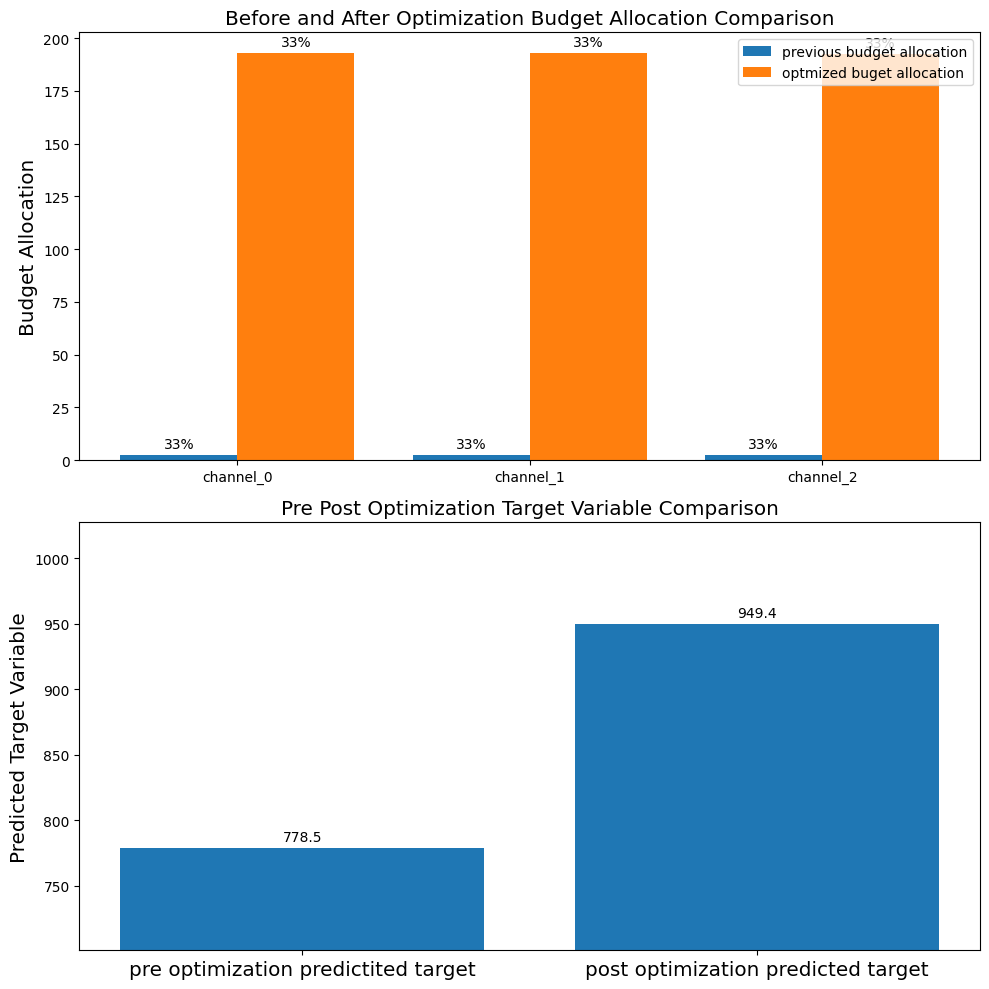

In [53]:
# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=mmm, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(10,10))

## Saving the model to disk

In [ ]:
# # We can use the utilities for saving models to disk.
# file_path = "media_mix_model.pkl"
# utils.save_model(media_mix_model=mmm, file_path='C:/Users/norri/Desktop/')

In [22]:
# # Once saved one can load the models.
# loaded_mmm = utils.load_model(file_path=file_path)
# loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.